In [1]:
import pandas as pd
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

from scipy.ndimage import rotate

from matplotlib import pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [23]:
# read in data
training = pd.read_csv("all/training.csv")
training.shape

(7049, 31)

In [3]:
training.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

# Data Validation 
## Check missing distributions

In [4]:
# check missing distribution
check1 = pd.isnull(training)
check2 = check1.groupby(list(check1.columns[:-1]))['Image'].value_counts().to_dict()

In [5]:
check3 = list(check1.groupby(list(check1.columns[:-1]))['Image'].count())
for i in range(len(check3)):
    print(i, ":", check3[i])

0 : 2140
1 : 13
2 : 3
3 : 4
4 : 3
5 : 1
6 : 3
7 : 26
8 : 1
9 : 1
10 : 2
11 : 31
12 : 1
13 : 2
14 : 6
15 : 1
16 : 2
17 : 1
18 : 3
19 : 1
20 : 1
21 : 2
22 : 1
23 : 1
24 : 1
25 : 4
26 : 2
27 : 1
28 : 1
29 : 1
30 : 2
31 : 1
32 : 3
33 : 2
34 : 4755
35 : 10
36 : 1
37 : 3
38 : 1
39 : 1
40 : 1
41 : 1
42 : 1
43 : 1
44 : 1
45 : 1
46 : 1
47 : 1
48 : 1
49 : 1


In [6]:
case = 6
for i in range(len(list(check2.items())[case][0])):
    print(i, list(check2.items())[case][0][i], ":", list(check1.columns)[i])

0 False : left_eye_center_x
1 False : left_eye_center_y
2 False : right_eye_center_x
3 False : right_eye_center_y
4 False : left_eye_inner_corner_x
5 False : left_eye_inner_corner_y
6 False : left_eye_outer_corner_x
7 False : left_eye_outer_corner_y
8 False : right_eye_inner_corner_x
9 False : right_eye_inner_corner_y
10 False : right_eye_outer_corner_x
11 False : right_eye_outer_corner_y
12 False : left_eyebrow_inner_end_x
13 False : left_eyebrow_inner_end_y
14 False : left_eyebrow_outer_end_x
15 False : left_eyebrow_outer_end_y
16 False : right_eyebrow_inner_end_x
17 False : right_eyebrow_inner_end_y
18 False : right_eyebrow_outer_end_x
19 False : right_eyebrow_outer_end_y
20 False : nose_tip_x
21 False : nose_tip_y
22 True : mouth_left_corner_x
23 True : mouth_left_corner_y
24 True : mouth_right_corner_x
25 True : mouth_right_corner_y
26 True : mouth_center_top_lip_x
27 True : mouth_center_top_lip_y
28 True : mouth_center_bottom_lip_x
29 True : mouth_center_bottom_lip_y
30 False : I

## Data Validation Findings

**2140 obs are non-missing (case 0)**

**4755 obs only have 8 non-missing key points (case 34)**
* False : left_eye_center_x
* False : left_eye_center_y
* False : right_eye_center_x
* False : right_eye_center_y
* False : nose_tip_x
* False : nose_tip_y
* False : mouth_center_bottom_lip_x
* False : mouth_center_bottom_lip_y
    
**31 obs only missing left_eyebrow_outer_end (case 11)**
* True : left_eyebrow_outer_end_x
* True : left_eyebrow_outer_end_y

**26 obs only missing right_eyebrow_outer_end (case 7)**
* True : right_eyebrow_outer_end_x
* True : right_eyebrow_outer_end_y

**13 obs only missing mouth_center_bottom_lip (case 1)**
* True : mouth_center_bottom_lip_x
* True : mouth_center_bottom_lip_y

**10 obs only have the following non-missing key points (case 35)**
* False : left_eye_center_x
* False : left_eye_center_y
* False : right_eye_center_x
* False : right_eye_center_y
* False : nose_tip_x
* False : nose_tip_y

**74 remaining obs have various missing points**

## Data Validation Decisions

Build two models, each to predict the following key points:

**model 1:**
number of non-missing observations: 7000
* left_eye_center
* right_eye_center
* nose_tip
* mouth_center_bottom_lip

**model 2:**
number of non-missing observations: 2155
* left_eye_inner_corner
* left_eye_outer_corner
* right_eye_inner_corner
* right_eye_outer_corner

* left_eyebrow_inner_end
* left_eyebrow_outer_end
* right_eyebrow_inner_end
* right_eyebrow_outer_end

* mouth_left_corner
* mouth_right_corner
* mouth_center_top_lip

In [10]:
# how many data points would we have?
points = [0, 1, 2, 3, 20, 21, 28, 29]
model = training.iloc[:, points]
print(model.shape)
model_nonmiss = model[~np.isnan(model).any(axis=1)]
print(model_nonmiss.shape)

(7049, 8)
(7000, 8)


In [11]:
points = list(range(4,20)) + list(range(22,28))
model = training.iloc[:, points]
print(model.shape)
model_nonmiss = model[~np.isnan(model).any(axis=1)]
print(model_nonmiss.shape)

(7049, 22)
(2155, 22)


# Data Preprocessing
## Split training and validation

In [24]:
# shuffle dataset
np.random.seed(666)
shuffle = np.random.permutation(np.arange(training.shape[0]))
training2 = training.iloc[shuffle].reset_index(drop=True)

# split out image values
image = []
for i in range(training2.shape[0]):
    img = training2['Image'][i].split(' ')
    img = ['0' if j == '' else j for j in img]
    image.append(img)

In [25]:
# create training and validation set (80/20 split)
X = np.array(image, dtype = 'float')
X_train, X_val = X[:5640], X[5640:]
print(X_train.shape, X_val.shape)

# create training and validation labels (80/20 split)
labels = training2.drop('Image', axis=1)
y = np.array(labels, dtype = 'float')
y_train, y_val = y[:5640], y[5640:]
print(y_train.shape, y_val.shape)

(5640, 9216) (1409, 9216)
(5640, 30) (1409, 30)


## Apply transformations

### 1. Mirroring

In [67]:
# define mirror functions
def mirror_X(input_X):
    return input_X.reshape(-1,96,96)[:, :, list(range(95, -1, -1))].reshape(-1, 96*96)
    
def mirror_y(input_y):
    output_y = y_train.copy()
    # y coordinate stays the same, x coordinate is 96-x
    output_y[:,list(range(0,29,2))] = 95 - input_y[:,list(range(0,29,2))]
    return output_y

In [68]:
# transform
X_train_mirror = mirror_X(X_train)
y_train_mirror = mirror_y(y_train)
# X_val_mirror = mirror_X(X_val)
# y_val_mirror = mirror_y(y_val)

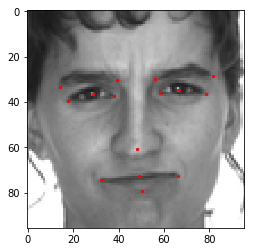

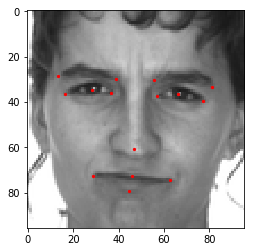

In [69]:
# check image
i=13
plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_mirror[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train_mirror[i, range(0, 30, 2)], y_train_mirror[i, range(1, 30, 2)], s=5, color='r')
plt.show()

### 2. Rotating

In [65]:
# mirror function to transform X
def rotate_X(input_X, degree):
    
    # create an array of the same size
    output_X = np.zeros((input_X.shape), dtype=np.float64)
    
    # for each image, use sklearn's rotate function to rotate image
    # this somehow changes pixel values, cap value between 0 and 255
    for i in range(output_X.shape[0]):
        output_X[i] = np.clip(rotate(input_X.reshape(-1,96,96)[i], degree, reshape=False, mode='constant', \
                                       cval=150).reshape(96*96), 0, 255)  
    return output_X
        
    
# mirror function to transform y
def rotate_y(input_y, degree):
    
    # create an array of same size
    output_y = np.zeros((input_y.shape), dtype=np.float64)
    
    # define rotation angle and center of rotation
    theta = np.radians(degree)
    center_x = 95/2
    center_y = 95/2

    for i in range(output_y.shape[0]):
        
        # obtain x and y coordinates from dataset
        x = input_y[i][np.arange(0,29,2)]
        y = input_y[i][np.arange(1,30,2)]
        
        # use rotation matrix to rotate coordinates around center
        x2 = np.cos(theta) * (x - center_x) + np.sin(theta) * (y - center_y) + center_x
        y2 = -np.sin(theta) * (x - center_x) + np.cos(theta) * (y - center_y) + center_y
        
        # put x and y back in original shape
        output_y[i] = np.vstack((x2,y2)).transpose().flatten()
        
    return output_y

In [66]:
# transform
X_train_rotate = rotate_X(X_train, -15)
y_train_rotate = rotate_y(y_train, -15)
# X_val_rotate = rotate_X(X_train, -15)
# y_val_rotate = rotate_y(y_train, -15)

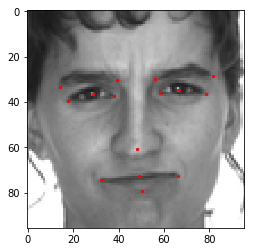

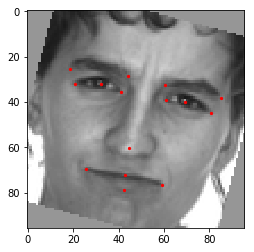

In [64]:
# check image
i=13

plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_rotate[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train_rotate[i, range(0, 30, 2)], y_train_rotate[i, range(1, 30, 2)], s=5, color='r')
plt.show()

### 3. Contrast Reduction

In [70]:
# define function - only need to transform X
def reduce_contrast(input_X, weight):
    return (weight * input_X) + (1 - weight) * input_X.mean()

In [71]:
# transform
X_train_contrast = reduce_contrast(X_train, 0.7)
# X_val_contrast = reduce_contrast(X_val, 0.7)

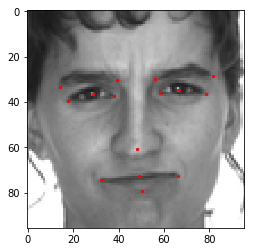

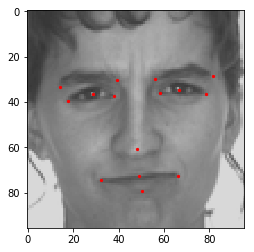

In [72]:
# check image
i=13

plt.imshow(X_train[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

plt.imshow(X_train_contrast[i].reshape(96,96),cmap='gray', vmin=0, vmax=255)
plt.scatter(y_train[i, range(0, 30, 2)], y_train[i, range(1, 30, 2)], s=5, color='r')
plt.show()

In [520]:
X_train_rotate.max()

343.64848890014355

In [502]:
test = rotate(X_train.reshape(-1,96,96)[3], degree, reshape=False).reshape(96*96)

In [504]:
X_train[3]

array([179., 179., 179., ...,  55.,  57.,  55.])

In [506]:
test.max()

239.34175779242386

In [ ]:
# mirroring
# rotation
# stretching
# shift 
# contrast reduction

In [43]:
~np.isnan(y_train).any(axis=1)[:100]

array([False, False,  True, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True,  True,  True,
       False,  True, False,  True,  True, False, False,  True, False,
       False, False,  True, False,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
       False])